# Investigate burst firing


## Imports

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import scipy.stats
#%matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from helpers import *
from utils import remove_top_right_frame, jitter_scatterplot

In [2]:
base_path = os.getcwd()
base_path = base_path.replace('notebooks', 'scripts') # note: if you have notebooks twice in your base_path, this won't work
sys.path.insert(1, base_path)

## Load Original Data (Only Run Once)

In [3]:
with open('data_bio482.pkl', 'rb') as file:
    data_df = pickle.load(file)

## Add AP Information (Only Run Once)

Using the Function_Detect_APs function, we can extract the details of the APs per sweep. For each entry in the original dataframe, we append the information about the APs in the Sweep_MembranePotential.

In [4]:
def explain_ap(ap_params):
    return {
        'ap_thresh_vm': ap_params[1],
        'ap_peak_times': ap_params[2],
        'ap_peak_vm': ap_params[3],
        'ap_peak_amp': ap_params[4],
        'ap_duration': ap_params[5]
    }

In [5]:
def process_sweep(row):
    """Process a single row to detect and explain action potentials."""
    sr_vm = row['Sweep_MembranePotential_SamplingRate']
    ap_vm_deriv_thresh = row['Cell_APThreshold_Slope']
    potential_across_time = row['Sweep_MembranePotential']

    # Detect action potentials
    ap_params = Function_Detect_APs(potential_across_time, sr_vm, ap_vm_deriv_thresh)

    # Return a dictionary of explained APs
    return {ap[0]: explain_ap(ap) for ap in ap_params}

In [6]:
# #RUN TO REWITE
# # Apply the function to each row
# ap_info = data_df.apply(process_sweep, axis=1)
# data_df['ap_info'] = ap_info

In [7]:
# #RUN TO REWRITE 
# file_to_save = "data_with_AP_info"
# #path = "/content/drive/MyDrive/NSCCM/" ## matthiew
# #data_df.to_pickle(f'{path}{file_to_save}.pkl')## matthiew
# data_df.to_pickle(f'{file_to_save}.pkl')   ## marine

## Import New Pickle

No need to run last 2 sections if you already have data_with_AP_info.pkl file in your directory. It is too large to push to github.

In [8]:
with open('data_with_AP_info.pkl', 'rb') as file:
    data_df = pickle.load(file)

## Visualise Data:

In [9]:
data_df.head()

,Cell_APThreshold_Slope,Cell_Anatomy,Cell_Counter,Cell_Depth,Cell_ID,Cell_Layer,Cell_TargetedBrainArea,Cell_Type,Cell_tdTomatoExpressing,Mouse_DateOfBirth,...,Sweep_MembranePotential,Sweep_MembranePotential_SamplingRate,Sweep_PassiveContactTimes,Sweep_QuietTimes,Sweep_StartTime,Sweep_Type,Sweep_WhiskerAngle,Sweep_WhiskerAngle_SamplingRate,Sweep_WhiskingTimes,ap_info
0,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,"[-0.044009375, -0.044028125, -0.0439875, -0.04...",20000.0,"[[4.567, 4.713], [7.327, 7.519], [14.481, 14.6...","[[0.002, 4.564], [4.606, 6.09], [14.634, 15.52...",2005.0,active touch,"[2.740000000000009, 2.740000000000009, 2.74000...",100.0,"[[6.118, 6.326], [7.942, 13.856]]","{1.3559: {'ap_thresh_vm': -0.033646875, 'ap_pe..."
1,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,"[-0.046275, -0.04629375, -0.046259375, -0.0462...",20000.0,"[[15.274999999999999, 15.375], [16.247, 16.643...","[[0.002, 4.496], [5.558, 6.626], [13.406, 15.2...",2005.0,active touch,"[2.680000000000007, 2.680000000000007, 2.68000...",100.0,"[[4.7, 5.196], [6.696, 11.15], [12.032, 13.006...","{4.9021: {'ap_thresh_vm': -0.03423125, 'ap_pea..."
2,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,"[-0.041896875, -0.0419125, -0.041909375, -0.04...",20000.0,"[[4.347000000000001, 7.0390000000000015], [8.2...","[[0.002, 2.128], [6.252, 7.01], [7.15, 20.0]]",2005.0,passive contact,"[1.4958937492820894, 1.5019819900587095, 1.509...",100.0,"[[2.15, 3.652], [4.362, 5.848]]","{2.13865: {'ap_thresh_vm': -0.03129375, 'ap_pe..."
3,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,"[-0.04655625, -0.0465875, -0.046575, -0.046596...",20000.0,nan,"[[0.002, 2.764], [12.03, 14.464], [14.814, 15....",2005.0,active touch,"[2.467493802679826, 2.459711310964792, 2.46562...",100.0,"[[2.766, 12.026], [15.626, 18.406], [18.814, 1...","{0.91115: {'ap_thresh_vm': -0.033, 'ap_peak_ti..."
4,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,"[-0.047296875, -0.047284375, -0.047265625, -0....",20000.0,"[[4.411000000000001, 4.4809999999999945], [5.2...","[[0.002, 3.36], [3.57, 4.424], [4.48, 5.224], ...",2005.0,active touch,"[2.4399999999999977, 2.4399999999999977, 2.440...",100.0,"[[5.228, 5.624], [7.462, 8.022], [11.002, 15.2...","{1.0954: {'ap_thresh_vm': -0.031940625, 'ap_pe..."


Each entry in the dataframe represents some sweep. There may be multiple sweeps per cell (as represented by Sweep_Counter) and so multiple entries with the same Cell_ID. Each entry has a Membrane Potential vs Time measure which can be visualised below:

In [10]:
def plot_aps(data_df, sweep_num, save_figure=False):

    sweep = data_df.iloc[sweep_num]

    sr_vm = sweep['Sweep_MembranePotential_SamplingRate']
    membrane_potential = sweep['Sweep_MembranePotential']
    
    time = [i/sr_vm for i in range(len(membrane_potential))]
    
    ap_peak_times = np.array([ap["ap_peak_times"] for ap in sweep["ap_info"].values()])
    ap_peak_vm = np.array([ap["ap_peak_vm"] for ap in sweep["ap_info"].values()])
    ap_thresh_vm = np.array([ap["ap_thresh_vm"] for ap in sweep["ap_info"].values()])
    ap_thresh_times = np.array([key for key in sweep["ap_info"].keys()])

    fig, ax = plt.subplots(1,1, figsize=(10,3), dpi=150)
    
    ax.set_title(f'APs for Sweep {sweep_num}')
    ax.plot(time, membrane_potential, lw=0.5,  zorder=0)
    ax.scatter(ap_peak_times, ap_peak_vm, lw=0.5, marker='+', color='r')
    ax.scatter(ap_thresh_times, ap_thresh_vm, lw=0.1, marker='o', color='b')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Vm (V)')
    plt.xlim(6,6.5)
    
    if save_figure:
        # Save figure
        fname = os.path.join('images', f'Example_Cell_{sweep_num}.png')
        plt.savefig(fname=fname, dpi='figure', format='png', bbox_inches='tight')


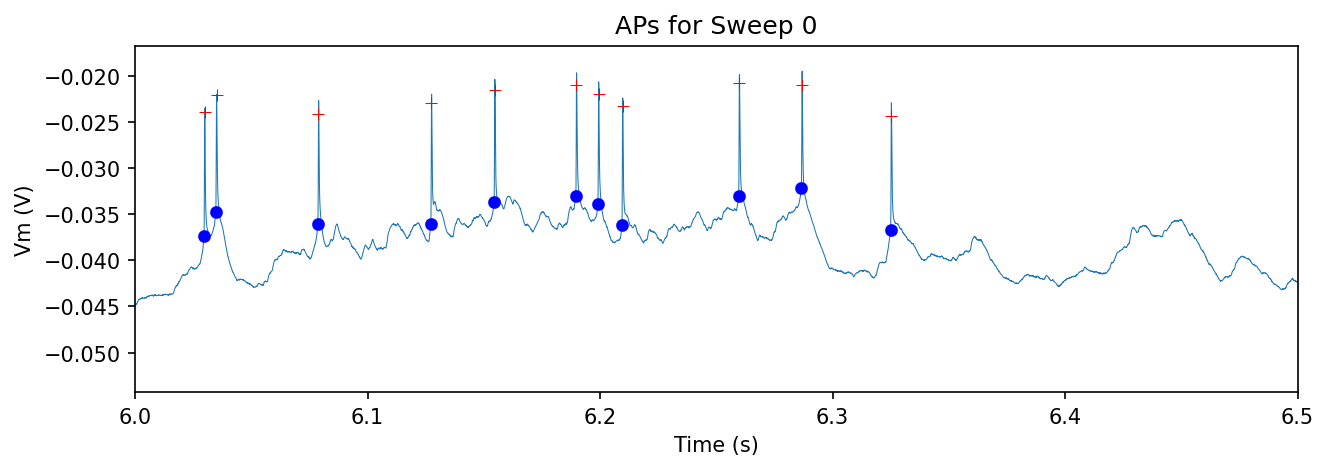

In [11]:
plot_aps(data_df, 0, save_figure = True)

## Identify Bursts for one sweep 

In [12]:
ap_df = pd.DataFrame.from_dict(data_df.ap_info[0], orient='index') #The index (row labels) represents the timestamps of the AP peaks 

In [13]:
#APs occurring within 30 ms of each other are considered part of the same burst
ap_df['peak_end_time'] = ap_df.index + ap_df['ap_duration'] / 1000 #Calculate the time at which each action potential (AP) ends.
ap_df['time_since_last_AP'] = ap_df.index - ap_df['peak_end_time'].shift(1) #Compute the time elapsed since the end of the last AP
ap_df['time_since_last_AP_2x'] = ap_df.index - ap_df['peak_end_time'].shift(2) #Compute the time elapsed since the end of the AP two positions prior: ensures bursts are detected over multiple APs.
ap_df['is_in_burst'] = ap_df['time_since_last_AP_2x'] < .03  #Identify if the AP is part of a burst based on timing.
ap_df['is_in_burst'] = ap_df['is_in_burst'] | ap_df['is_in_burst'].shift(-1) | ap_df['is_in_burst'].shift(-2)#Refine the identification of bursts by considering neighboring APs.

In [14]:
ap_df.head()

,ap_thresh_vm,ap_peak_times,ap_peak_vm,ap_peak_amp,ap_duration,peak_end_time,time_since_last_AP,time_since_last_AP_2x,is_in_burst
1.35590,-0.033647,1.3562,-0.021266,0.012381,0.35,1.35625,NaN,NaN,False
2.99410,-0.037781,2.9944,-0.024581,0.013200,0.35,2.99445,1.63785,NaN,False
4.57150,-0.043684,4.5718,-0.030378,0.013306,0.45,4.57195,1.57705,3.21525,False
4.70110,-0.034181,4.7014,-0.021247,0.012934,0.40,4.70150,0.12915,1.70665,False
4.78105,-0.034022,4.7813,-0.022019,0.012003,0.40,4.78145,0.07955,0.20910,False


In [15]:
def burst_times(ap_df):
    '''identify and extract bursts of activity from the action potential (AP) data in ap_df.
    A burst is defined based on the criteria already encoded in the is_in_burst column of ap_df
    
    - ap_df (DataFrame) containing 'is_in_burst' column indicating whether each AP is part of a burs,
            and a 'peak_end_time' column for the end time of each AP.
            
    Returns :
    bursts: A list of tuples representing bursts. Each tuple contains:
        Burst start time (burst_start).
        Burst end time (burst_end).
        Number of APs in the burst (j - i + 1).
    '''
    bursts = []
    i = 0
    while i < len(ap_df):
        row = ap_df.iloc[i]
        is_in_burst = row['is_in_burst']
        if is_in_burst:
            burst_start = row.name
            for j in range(i, len(ap_df)):
                row_1 = ap_df.iloc[j]
                if j == len(ap_df)-1:
                    # we have reached last peak in sweep
                    burst_end = row_1['peak_end_time']
                    bursts.append((burst_start, burst_end, j-i+1))
                    break
                row_2 = ap_df.iloc[j+1]
                if not row_2['is_in_burst']:
                    # we have reached peak which is not in this burst
                    burst_end = row_1['peak_end_time']
                    bursts.append((burst_start, burst_end, j-i+1))
                    break
                else:
                    continue
            i = j
        i += 1
    return bursts

In [16]:
burst_times(ap_df)

[(6.18955, 6.209849999999999, 3)]

## Bursts for all sweeps

In [17]:
##RUN TO REWRITE 
# burst_times_per_sweep = []

# for i in range(len(data_df)):
#     if i % 10 == 0:
#         print(f"completing sweep {i+1}")
#     ap_df = pd.DataFrame.from_dict(data_df.ap_info[i], orient='index')
#     if len(ap_df):
#         ap_df['peak_end_time'] = ap_df.index + ap_df['ap_duration'] / 1000
#         ap_df['time_since_last_AP'] = ap_df.index - ap_df['peak_end_time'].shift(1) 
#         ap_df['time_since_last_AP_2x'] = ap_df.index - ap_df['peak_end_time'].shift(2) 
#         ap_df['is_final_in_burst'] = ap_df['time_since_last_AP_2x'] < .03 
#         ap_df['is_in_burst'] = ap_df['is_final_in_burst'] | ap_df['is_final_in_burst'].shift(-1) | ap_df['is_final_in_burst'].shift(-2)
#         burst_info = burst_times(ap_df)
#         burst_times_per_sweep.append(burst_info)
#         print(f"found {len(burst_info)} bursts")
#     else:
#         print(f"found no peaks")
#         burst_times_per_sweep.append([]) 
    

In [18]:
##RUN TO REWRITE 

#file_path = "data_with_burst_info.txt"

## Write the list to a text file
#with open(file_path, "w") as file:
#    for item in burst_times_per_sweep:
#        file.write(f"{item}\n")

#### Add burst info for each sweep to the data_df dataftame   

In [19]:
#load burst_times_per_sweep
import ast

file_path = "data_with_burst_info.txt"
burst_times_per_sweep = []
# Open and read the text file
with open(file_path, "r") as file:
    for line in file:
        burst_times_per_sweep.append(ast.literal_eval(line.strip()))

In [20]:
# add a column to data_df containing burst_times_per_sweep
# each sweep has format [(start, stop, nb_of_ap), (start, stop, nb_of_ap), ...]
data_df['burst_info'] = burst_times_per_sweep

# add col for nb of burts 
data_df['nb_of_bursts'] = data_df['burst_info'].apply(len)

#add col for mean burst duration ->TODO check is there is a lot of diversity in the duration : pertinent to do mean ?
def mean_burst_duration(burst_inf):
    if not burst_inf:
        return 0
    durations = [stop-start for start, stop, _ in burst_inf]
    return sum(durations)/len(durations)

data_df['mean_burst_duration_sweep'] = data_df['burst_info'].apply(lambda x: mean_burst_duration(x) )

In [21]:
data_df

,Cell_APThreshold_Slope,Cell_Anatomy,Cell_Counter,Cell_Depth,Cell_ID,Cell_Layer,Cell_TargetedBrainArea,Cell_Type,Cell_tdTomatoExpressing,Mouse_DateOfBirth,...,Sweep_QuietTimes,Sweep_StartTime,Sweep_Type,Sweep_WhiskerAngle,Sweep_WhiskerAngle_SamplingRate,Sweep_WhiskingTimes,ap_info,burst_info,nb_of_bursts,mean_burst_duration_sweep
0,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,"[[0.002, 4.564], [4.606, 6.09], [14.634, 15.52...",2005.0,active touch,"[2.740000000000009, 2.740000000000009, 2.74000...",100.0,"[[6.118, 6.326], [7.942, 13.856]]","{1.3559: {'ap_thresh_vm': -0.033646875, 'ap_pe...","[(6.18955, 6.209849999999999, 3)]",1,0.020300
1,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,"[[0.002, 4.496], [5.558, 6.626], [13.406, 15.2...",2005.0,active touch,"[2.680000000000007, 2.680000000000007, 2.68000...",100.0,"[[4.7, 5.196], [6.696, 11.15], [12.032, 13.006...","{4.9021: {'ap_thresh_vm': -0.03423125, 'ap_pea...","[(6.9207, 7.02135, 7), (7.11825, 7.14849999999...",4,0.045000
2,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,"[[0.002, 2.128], [6.252, 7.01], [7.15, 20.0]]",2005.0,passive contact,"[1.4958937492820894, 1.5019819900587095, 1.509...",100.0,"[[2.15, 3.652], [4.362, 5.848]]","{2.13865: {'ap_thresh_vm': -0.03129375, 'ap_pe...","[(2.2695, 2.28755, 3), (4.4129, 4.43405, 3), (...",5,0.045900
3,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,"[[0.002, 2.764], [12.03, 14.464], [14.814, 15....",2005.0,active touch,"[2.467493802679826, 2.459711310964792, 2.46562...",100.0,"[[2.766, 12.026], [15.626, 18.406], [18.814, 1...","{0.91115: {'ap_thresh_vm': -0.033, 'ap_peak_ti...","[(0.91115, 0.94065, 3), (2.74875, 2.78715, 4),...",27,0.060450
4,10.0,L2/3,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,"[[0.002, 3.36], [3.57, 4.424], [4.48, 5.224], ...",2005.0,active touch,"[2.4399999999999977, 2.4399999999999977, 2.440...",100.0,"[[5.228, 5.624], [7.462, 8.022], [11.002, 15.2...","{1.0954: {'ap_thresh_vm': -0.031940625, 'ap_pe...","[(3.7138, 3.75135, 4), (4.4441, 4.46295, 3), (...",6,0.031717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826,20.0,nan,1.0,196.0,AP068_1,L2/3,C2,SST,True,2015.0,...,"[[0.002, 10.728], [17.854, 20.0]]",2015.0,free whisking,"[-139.2381, -139.2381, -139.2381, -139.2381, -...",100.0,"[11.022, 16.274]","{0.07505: {'ap_thresh_vm': -0.048921876, 'ap_p...","[(3.4687, 3.4969, 3), (4.3082, 4.3290999999999...",4,0.027300
827,20.0,nan,1.0,196.0,AP068_1,L2/3,C2,SST,True,2015.0,...,"[[0.002, 0.238], [1.162, 3.608], [4.906, 6.216...",2015.0,free whisking,"[-144.9738, -144.9738, -144.9738, -145.6111, -...",100.0,"[[0.264, 1.158], [3.694, 4.776], [8.728, 9.896...","{0.5822: {'ap_thresh_vm': -0.04911875, 'ap_pea...","[(5.1003, 5.13595, 4), (9.6326, 9.6623, 3)]",2,0.032675
828,20.0,nan,1.0,196.0,AP068_1,L2/3,C2,SST,True,2015.0,...,"[[0.002, 1.74], [1.844, 6.52], [6.532, 9.15], ...",2015.0,free whisking,"[-150.0723, -150.0723, -150.0723, -150.0723, -...",100.0,"[[9.166, 9.878], [10.358, 12.526], [12.958, 13...","{0.02425: {'ap_thresh_vm': -0.047346875, 'ap_p...","[(4.38505, 4.4131, 3), (10.49595, 10.53575, 4)...",4,0.035725
829,20.0,nan,1.0,196.0,AP068_1,L2/3,C2,SST,True,2015.0,...,"[[0.002, 0.146], [0.53, 1.858], [2.408, 3.664]...",2015.0,free whisking,"[-144.9738, -144.9738, -144.9738, -145.6111, -...",100.0,"[[0.222, 0.526], [1.892, 2.404], [3.692, 3.818...","{0.0596: {'ap_thresh_vm': -0.047421876, 'ap_pe...","[(0.0596, 0.08785, 3), (9.5046, 9.52465, 3), (...",3,0.025317


## Analyse bursting behavior of neurons 

### Define metrics to categorise neurons according to their bursting behavior:
- mean number of burst 
- mean burst duration

In [22]:
def plot_metrics(df_metric, x):
    '''
    plots subplots of all metrics for x
    
    - df_metric (DataFrame): dataframe with 1 column x and multiple colums for metrics (but no other kind of columns)
    - x (str): the x axis (ex 'Cell_Type' or 'Cell_layer') 
    '''
    # create list of metrics : columns except x
    metrics = df_metric.columns.difference([x])

    # Create subplots dynamically
    fig, axes = plt.subplots(1, len(metrics), figsize=(6 * len(metrics), 6), sharey=False)

    # color palette based on the unique x values
    palette_x = sns.color_palette("Set2", n_colors=len(df_metric[x].unique()))

    # Iterate through metrics and plot each one
    for ax, metric in zip(axes, metrics):
        ax.bar(df_metric[x], df_metric[metric], color=palette_x)
        ax.set_xlabel(x)
        ax.set_ylabel(metric.replace('_', ' ').capitalize())
        ax.set_title(f'{metric.replace("_", " ").capitalize()} by {x}')

    plt.tight_layout()
    plt.show()

#### Per cell type

In [23]:
# Calculate metrics
mean_nb_burst_cell_type = data_df.groupby('Cell_Type')['nb_of_bursts'].mean()
mean_burst_duration_cell_type = data_df.groupby('Cell_Type')['mean_burst_duration_sweep'].mean()

# Create DataFrame and combine metrics
cell_type_metrics = pd.DataFrame({
    'Cell_Type': mean_nb_burst_cell_type.index,
    'mean_nb_bursts': mean_nb_burst_cell_type.values,
    'mean_burst_duration': mean_burst_duration_cell_type.values
})
cell_type_metrics

,Cell_Type,mean_nb_bursts,mean_burst_duration
0,EXC,2.218130,0.033485
1,PV,68.302469,0.190791
2,SST,13.533333,0.061142
3,VIP,27.000000,0.068429


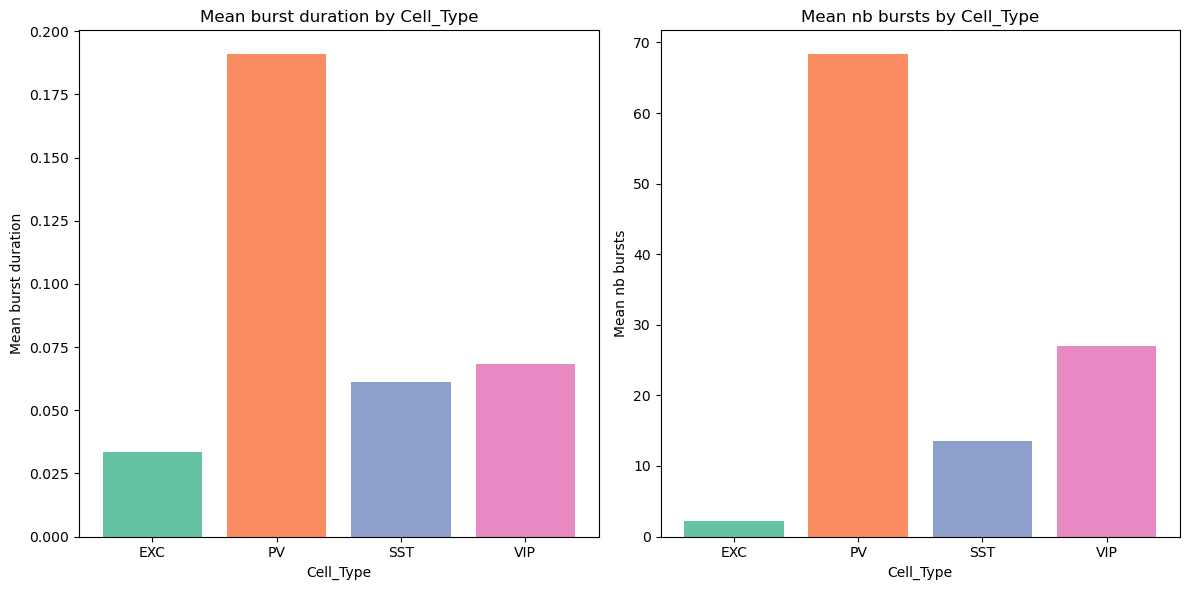

In [24]:
plot_metrics(cell_type_metrics, 'Cell_Type')

#### Per cell layer

In [25]:
# Calculate metrics
mean_nb_burst_layer = data_df.groupby('Cell_Layer')['nb_of_bursts'].mean()
mean_burst_duration_layer = data_df.groupby('Cell_Layer')['mean_burst_duration_sweep'].mean()

# Create DataFrame and combine metrics
layer_metrics = pd.DataFrame({
    'Cell_Layer': mean_nb_burst_layer.index,
    'mean_nb_bursts': mean_nb_burst_layer.values,
    'mean_burst_duration': mean_burst_duration_layer.values
})

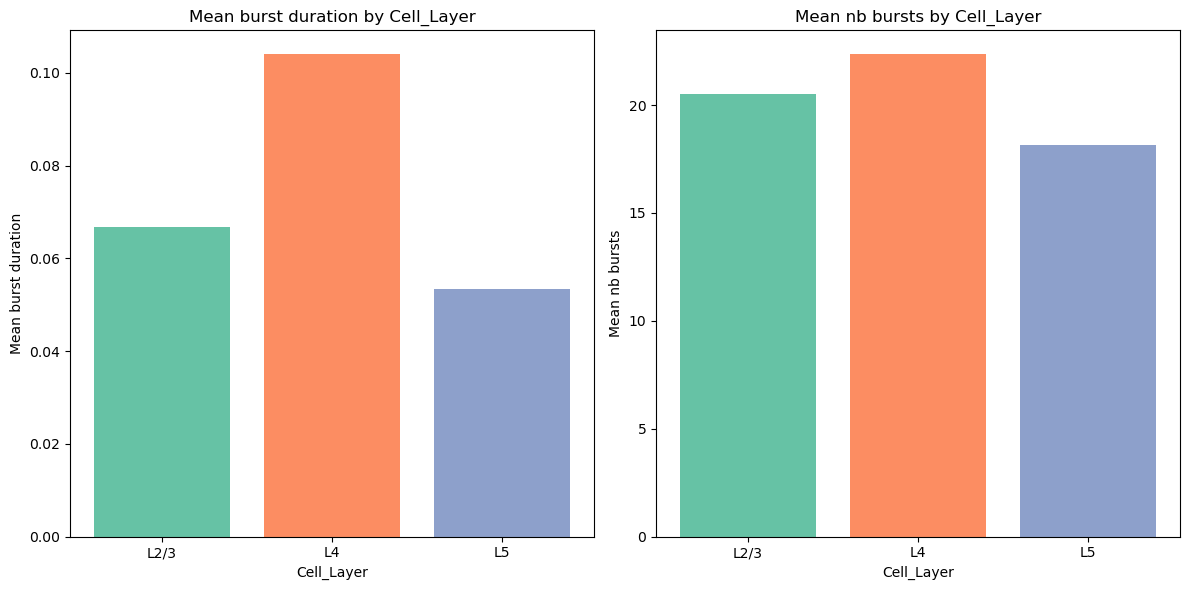

In [26]:
plot_metrics(layer_metrics,'Cell_Layer')

### Cell depth 

In [27]:
# Calculate metrics
mean_nb_burst_depth = data_df.groupby('Cell_Depth')['nb_of_bursts'].mean()
mean_burst_duration_depth = data_df.groupby('Cell_Depth')['mean_burst_duration_sweep'].mean()

# Create DataFrame and combine metrics
depth_metrics = pd.DataFrame({
    'Cell_Depth': mean_nb_burst_depth.index,
    'mean_nb_bursts': mean_nb_burst_depth.values,
    'mean_burst_duration': mean_burst_duration_depth.values
})

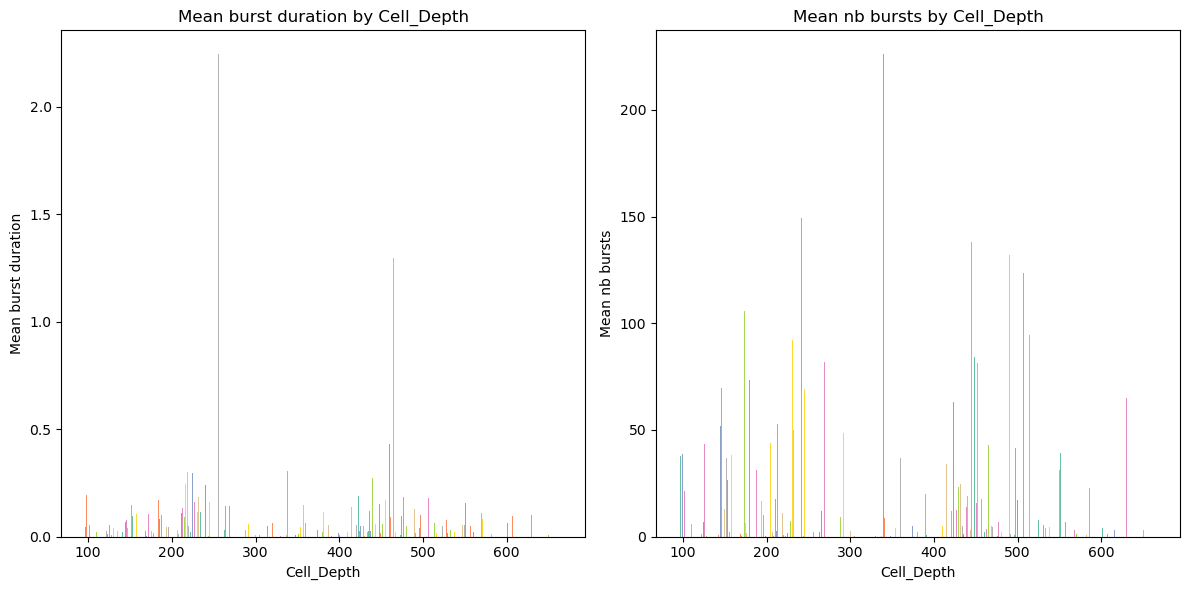

In [28]:
plot_metrics(depth_metrics, 'Cell_Depth')

### Targeted brain area

In [29]:
# Calculate metrics
mean_nb_burst_area = data_df.groupby('Cell_TargetedBrainArea')['nb_of_bursts'].mean()
mean_burst_duration_area = data_df.groupby('Cell_TargetedBrainArea')['mean_burst_duration_sweep'].mean()

# Create DataFrame and combine metrics
area_metrics = pd.DataFrame({
    'Cell_TargetedBrainArea': mean_nb_burst_area.index,
    'mean_nb_bursts': mean_nb_burst_area.values,
    'mean_burst_duration': mean_burst_duration_area.values
})

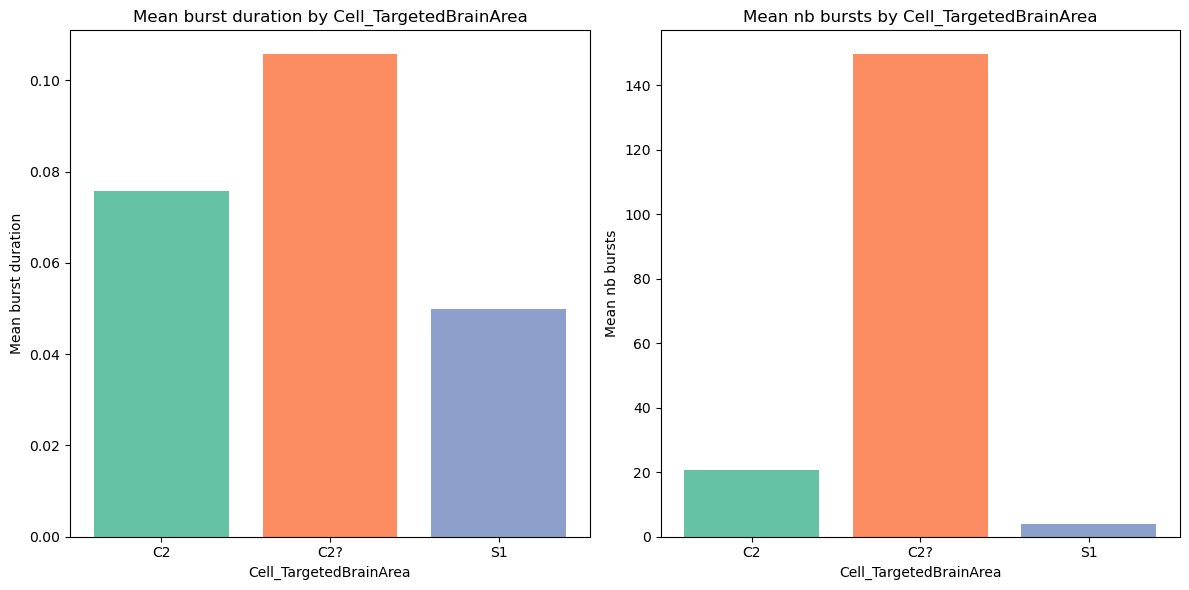

In [30]:
plot_metrics(area_metrics,'Cell_TargetedBrainArea')

## Map mouse activity (quiet, wisking, touch) and busrt to every recording-timepoint

### Get recording timepoints of each sweep 

In [32]:
#adding a column for timepoints: array of all timepoints where measures were made
sampling_rate = data_df['Sweep_MembranePotential_SamplingRate'].iloc[0] #always the same 20000.
data_df['time_points'] = data_df['Sweep_MembranePotential'].apply(lambda x: np.linspace(0, len(x)/sampling_rate , num=len(x)+1))


In [33]:
data_df['time_points']

0      [0.0, 5e-05, 0.0001, 0.00015000000000000001, 0...
1      [0.0, 5e-05, 0.0001, 0.00015000000000000001, 0...
2      [0.0, 5e-05, 0.0001, 0.00015000000000000001, 0...
3      [0.0, 5e-05, 0.0001, 0.00015000000000000001, 0...
4      [0.0, 5e-05, 0.0001, 0.00015000000000000001, 0...
                             ...                        
826    [0.0, 5e-05, 0.0001, 0.00015000000000000001, 0...
827    [0.0, 5e-05, 0.0001, 0.00015000000000000001, 0...
828    [0.0, 5e-05, 0.0001, 0.00015000000000000001, 0...
829    [0.0, 5e-05, 0.0001, 0.00015000000000000001, 0...
830    [0.0, 5e-05, 0.0001, 0.00015000000000000001, 0...
Name: time_points, Length: 831, dtype: object

### Get filter for burst
Define if each timepoint is within a burst, for every sweep

In [34]:
#adding a column to data_df corresonding to a burst boolean of each timepoint 
def compute_burst_filter(time_points, burst_info):
    # Create a zero array of the same length as time_points
    burst_filter = np.zeros(len(time_points), dtype=int)
    
    # Iterate through each (start, end, n) tuple in burst_info
    for start, end, _ in burst_info:
        # Mark indices where time_points are within the burst interval
        burst_filter[(time_points >= start) & (time_points <= end)] = 1
    
    return burst_filter

data_df['burst_filter'] = data_df.apply(lambda row: compute_burst_filter(np.array(row['time_points']), row['burst_info']), axis=1)

In [106]:
values, count = np.unique(data_df['burst_filter'][0],return_counts = True)
print(f'In the first sweep, there are {count[0]} timepoints classified as non-burst, and {count[1]} timepoints classified as burst ')

In the first sweep, there are 399595 timepoints classified as non-burst, and 406 timepoints classified as burst 


### Get filter for quiet times
Define if each timepoint is classified as quiet, for every sweep

In [108]:

def compute_action_filter(time_points, action_times):
    ''' 
    Computes the filter for a single row of data_df.
    Returns the filter: list of 0s and 1s indicating if the timepoint corresponds to the action.
    '''
    # Check for NaN or invalid cases
    if action_times is None or np.isnan(action_times).all():
        print('None encountered, was set to 0')
        return np.zeros(len(time_points), dtype=int)
    
    # Ensure action_times is a numpy array with shape (n, 2) where each row is a (start, end) pair
    if not isinstance(action_times, np.ndarray):
        print('Action_times is not a numpy array, was set to 0')
        return np.zeros(len(time_points), dtype=int)

    if len(action_times) == 0:
        print('No action in this sweep, was set to 0')
        return np.zeros(len(time_points), dtype=int)
    
    burst_filter = np.zeros(len(time_points), dtype=int)

    # Check if only one burst
    if action_times.ndim == 1:
        start = action_times[0]
        end = action_times[1]
        # Ensure that start and end are floats or numeric values
        if isinstance(start, (int, float)) and isinstance(end, (int, float)):
            # Mark indices where time_points are within the action interval
            burst_filter[(time_points >= start) & (time_points <= end)] = 1
        else:
            print(f"Invalid start or end value: {start}, {end}. Skipping this pair.")
        return np.zeros(len(time_points), dtype=int)
    
    # Check that each element in action_times is a pair (start, end)
    if action_times.ndim != 2 or action_times.shape[1] != 2:
        print(f'Action_times is not properly structured, was set to 0 {action_times}')
        return np.zeros(len(time_points), dtype=int)

    # Iterate through each (start, end) pair in action_times
    for start, end in action_times:
        # Ensure that start and end are floats or numeric values
        if isinstance(start, (int, float)) and isinstance(end, (int, float)):
            # Mark indices where time_points are within the action interval
            burst_filter[(time_points >= start) & (time_points <= end)] = 1
        else:
            print(f"Invalid start or end value: {start}, {end}. Skipping this pair.")
    
    return burst_filter


In [107]:
data_df['quiet_filter'] = data_df.apply(lambda row: compute_action_filter(np.array(row['time_points']),row['Sweep_QuietTimes']), axis=1)

None encountered, was set to 0


In [109]:
values, count = np.unique(data_df['quiet_filter'][0],return_counts = True)
print(f'In the first sweep, there are {count[0]} timepoints classified as non-quiet, and {count[1]} timepoints classified as quiet ')

In the first sweep, there are 193036 timepoints classified as non-quiet, and 206965 timepoints classified as quiet 


### Get filter for wisking times
Define if each timepoint is classified as wisking, for every sweep

In [110]:
data_df['wisking_filter'] = data_df.apply(lambda row: compute_action_filter(np.array(row['time_points']),row['Sweep_WhiskingTimes']), axis=1)

None encountered, was set to 0
None encountered, was set to 0


In [111]:
values, count = np.unique(data_df['wisking_filter'][0],return_counts = True)
print(f'In the first sweep, there are {count[0]} timepoints classified as non-wisking, and {count[1]} timepoints classified as wisking ')

In the first sweep, there are 277560 timepoints classified as non-wisking, and 122441 timepoints classified as wisking 


### contact timepoints 

In [100]:

data_df['a_contact_filter'] = data_df.apply(lambda row: compute_action_filter(np.array(row['time_points']),row['Sweep_ActiveContactTimes']), axis=1)
data_df['p_contact_filter'] = data_df.apply(lambda row: compute_action_filter(np.array(row['time_points']),row['Sweep_PassiveContactTimes']), axis=1)

None encountered, was set to 0
None encountered, was set to 0
None encountered, was set to 0
None encountered, was set to 0
None encountered, was set to 0
None encountered, was set to 0
None encountered, was set to 0
None encountered, was set to 0
None encountered, was set to 0
None encountered, was set to 0
None encountered, was set to 0
None encountered, was set to 0
None encountered, was set to 0
None encountered, was set to 0
None encountered, was set to 0
None encountered, was set to 0
None encountered, was set to 0
None encountered, was set to 0
None encountered, was set to 0
None encountered, was set to 0
None encountered, was set to 0
None encountered, was set to 0
None encountered, was set to 0
None encountered, was set to 0
None encountered, was set to 0
None encountered, was set to 0
None encountered, was set to 0
None encountered, was set to 0
None encountered, was set to 0
None encountered, was set to 0
None encountered, was set to 0
None encountered, was set to 0
None enc

In [112]:
values, count = np.unique(data_df['a_contact_filter'][0],return_counts = True)
print(f'In the first sweep, there are {count[0]} timepoints classified as non-active-touch, and {count[1]} timepoints classified as active-touch ')

In the first sweep, there are 396313 timepoints classified as non-active-touch, and 3688 timepoints classified as active-touch 


In [113]:
values, count = np.unique(data_df['p_contact_filter'][0],return_counts = True)
print(f'In the first sweep, there are {count[0]} timepoints classified as non-passive-touch, and {count[1]} timepoints classified as passive-touch ')

In the first sweep, there are 368835 timepoints classified as non-passive-touch, and 31166 timepoints classified as passive-touch 
